# 3 Pre-Processing and Training Data<a id='4_Pre-Processing_and_Training_Data'></a>

The objectives of this notebook is to create a machine learning capable to segmentize a given Tweet into its category. We will be using a natural language processing modeling method called word embedding to define the clusters of the tweets, then measure the overall sentiments of all Tweets in a given day to predict the closing price.


Guidance from Springboard:
* Create dummy or indicator features for categorical variables
* Standardize the magnitude of numeric features using a scaler
* Split your data into testing and training datasets

## 3.1 Imports<a id='4.3_Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

In [2]:
#Importing stock data from previous notebook "02_Exploratory_Data_Analysis"
eda_stock_data = pd.read_csv('eda_stock_data.csv', encoding='latin-1')
eda_stock_data.reset_index(drop=True, inplace=True)
eda_stock_data.head()

,Dates,Time,Volume,%_change_Open,%_change_High,%_change_Low,%_change_Close,%_change_Volume
0,2022-10-03,00:00:00,114311700,NaN,NaN,NaN,NaN,NaN
1,2022-10-04,00:00:00,87830100,4.934514,2.201715,4.771583,2.562311,-23.166133
2,2022-10-05,00:00:00,79471000,-0.661926,0.793328,-0.866491,0.205326,-9.517352
3,2022-10-06,00:00:00,68402200,1.207739,0.108555,1.545351,-0.662562,-13.928100
4,2022-10-07,00:00:00,85925600,-2.242648,-3.009345,-3.973285,-3.671873,25.618182


In [3]:
#Importing tweet data from previous notebook "02_Exploratory_Data_Analysis"
trading_hours_tweets = pd.read_csv('trading_hours_tweets.csv', encoding='latin-1')
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis
0,2022-10-30,20:29:52,nicrae45,0,Twitter for iPhone,lol,0.700,0.800,Positive
1,2022-10-30,20:29:00,0x1585D65F0,1,Twitter for iPhone,4ch3t3 _syco hehe butterfly issues 2.0,0.000,0.000,Neutral
2,2022-10-30,20:28:34,equitydd,1,Twitter for iPhone,2011 this is $aapl trend line that played out...,0.325,0.325,Positive
3,2022-10-30,20:28:31,THESMARR,0,Twitter Web App,can yâall give her own pink iphone ???,0.650,0.250,Positive
4,2022-10-30,20:28:26,_Idontknowbro_,0,Twitter for iPhone,ios16 is messing with my phone service yâal...,0.600,0.200,Positive


## 3.2 Text Mining

Text Mining is the process of deriving meaningful information from natural language text. Natural Language Processing(NLP) is a part of computer science and artificial intelligence which deals with human languages.

### 3.2.1 Tokenization

Here we turn our twitter strings to lists of individual tokens (words, punctuations). Tokenization is the first step in NLP. It is the process of breaking strings into tokens which in turn are small structures or units. Tokenization involves three steps which are breaking a complex sentence into words, understanding the importance of each word with respect to the sentence and finally produce structural description on an input sentence.

In [4]:
from nltk.tokenize import RegexpTokenizer

#NLTK tokenizer
tokenizer = RegexpTokenizer(r'\w+')
trading_hours_tweets['tokens'] = trading_hours_tweets['text'].apply(tokenizer.tokenize)
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,tokens
0,2022-10-30,20:29:52,nicrae45,0,Twitter for iPhone,lol,0.700,0.800,Positive,[lol]
1,2022-10-30,20:29:00,0x1585D65F0,1,Twitter for iPhone,4ch3t3 _syco hehe butterfly issues 2.0,0.000,0.000,Neutral,"[4ch3t3, _syco, hehe, butterfly, issues, 2, 0]"
2,2022-10-30,20:28:34,equitydd,1,Twitter for iPhone,2011 this is $aapl trend line that played out...,0.325,0.325,Positive,"[2011, this, is, aapl, trend, line, that, play..."
3,2022-10-30,20:28:31,THESMARR,0,Twitter Web App,can yâall give her own pink iphone ???,0.650,0.250,Positive,"[can, yâ, all, give, her, own, pink, iphone]"
4,2022-10-30,20:28:26,_Idontknowbro_,0,Twitter for iPhone,ios16 is messing with my phone service yâal...,0.600,0.200,Positive,"[ios16, is, messing, with, my, phone, service,..."


### 3.2.2 Sentence Length

Using the tokens that we generated, we want to explore sentence length and vocabulary size

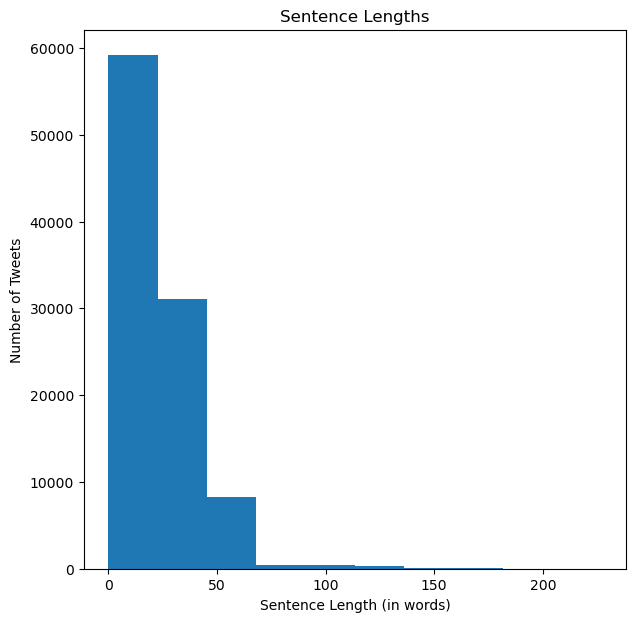

In [5]:
sentence_lengths = [len(tokens) for tokens in trading_hours_tweets['tokens']]
vocab = sorted(list(set([word for tokens in trading_hours_tweets['tokens'] for word in tokens])))

plt.figure(figsize = (7,7))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [6]:
print('We have a vocabulary size of', len(vocab), 'unique words')

We have a vocabulary size of 56830 unique words


### 3.2.3 Removing Stop Words

“Stop words” are the most common words in a language like “the”, “a”, “at”, “for”, “above”, “on”, “is”, “all”. These words do not provide any meaning and are usually removed from texts. We can remove these stop words using nltk library

In [7]:
# importing stopwords from nltk library
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')

# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
trading_hours_tweets['tweet_without_stopwords'] = trading_hours_tweets['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,tokens,tweet_without_stopwords
0,2022-10-30,20:29:52,nicrae45,0,Twitter for iPhone,lol,0.700,0.800,Positive,[lol],lol
1,2022-10-30,20:29:00,0x1585D65F0,1,Twitter for iPhone,4ch3t3 _syco hehe butterfly issues 2.0,0.000,0.000,Neutral,"[4ch3t3, _syco, hehe, butterfly, issues, 2, 0]",4ch3t3 _syco hehe butterfly issues 2.0
2,2022-10-30,20:28:34,equitydd,1,Twitter for iPhone,2011 this is $aapl trend line that played out...,0.325,0.325,Positive,"[2011, this, is, aapl, trend, line, that, play...","2011 $aapl trend line played summer rally, pen..."
3,2022-10-30,20:28:31,THESMARR,0,Twitter Web App,can yâall give her own pink iphone ???,0.650,0.250,Positive,"[can, yâ, all, give, her, own, pink, iphone]",yâall give pink iphone ???
4,2022-10-30,20:28:26,_Idontknowbro_,0,Twitter for iPhone,ios16 is messing with my phone service yâal...,0.600,0.200,Positive,"[ios16, is, messing, with, my, phone, service,...",ios16 messing phone service yâall need fix fast


### 3.2.4 Lemmitization

In simpler terms, lemmitization is the process of converting a word to its base form. Lemmatization considers the context and converts the word to its meaningful base form. For example, lemmatization would correctly identify the base form of ‘caring’ to ‘care'. This is extremely valuable because we want to identify key words that lead to negative, positive and neutral sentiments.

In [8]:
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

trading_hours_tweets['tweet_lemmatized'] = trading_hours_tweets['tweet_without_stopwords'].apply(lemmatize_text)
trading_hours_tweets.head()

,Dates,Time,user,likes,source,text,Subjectivity,Polarity,Analysis,tokens,tweet_without_stopwords,tweet_lemmatized
0,2022-10-30,20:29:52,nicrae45,0,Twitter for iPhone,lol,0.700,0.800,Positive,[lol],lol,[lol]
1,2022-10-30,20:29:00,0x1585D65F0,1,Twitter for iPhone,4ch3t3 _syco hehe butterfly issues 2.0,0.000,0.000,Neutral,"[4ch3t3, _syco, hehe, butterfly, issues, 2, 0]",4ch3t3 _syco hehe butterfly issues 2.0,"[4ch3t3, _syco, hehe, butterfly, issue, 2.0]"
2,2022-10-30,20:28:34,equitydd,1,Twitter for iPhone,2011 this is $aapl trend line that played out...,0.325,0.325,Positive,"[2011, this, is, aapl, trend, line, that, play...","2011 $aapl trend line played summer rally, pen...","[2011, $aapl, trend, line, played, summer, ral..."
3,2022-10-30,20:28:31,THESMARR,0,Twitter Web App,can yâall give her own pink iphone ???,0.650,0.250,Positive,"[can, yâ, all, give, her, own, pink, iphone]",yâall give pink iphone ???,"[yâall, give, pink, iphone, ???]"
4,2022-10-30,20:28:26,_Idontknowbro_,0,Twitter for iPhone,ios16 is messing with my phone service yâal...,0.600,0.200,Positive,"[ios16, is, messing, with, my, phone, service,...",ios16 messing phone service yâall need fix fast,"[ios16, messing, phone, service, yâall, need..."


## 3.3 Feature Engineering

In [9]:
import nltk; nltk.download('averaged_perceptron_tagger'); nltk.download('punkt')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 3.3.1 Embedding

Word embedding is one of the most popular representation of document vocabulary. It is capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc. What are word embeddings exactly? Loosely speaking, they are vector representations of a particular word. In this project, we will use Word2Vec embedding method to map a word to a fixed-length vector. 

In simple terms, words that have similar meanings or are related closely, when mapped into a vector space would appear closer, like in a cluster. This can help us understand the semantics of the words in a sentence better than any previously mentioned technique. 